# Mutual Information for Gaussian Variables

The mutual information for two continuous variables is defined as follows.

$I(X;Y) = \int_y \int_x p(x, y) \log \cfrac{p(x, y)}{p(x)p(y)}$

Computing the mutual information is prohibitive since the number of possible values of $X$ and $Y$ could be very large, and the product of the numbers of possible values is even larger. Here, we will use an approximation to computing the mutual information. First, we will assume that the $X$ and $Y$ are gaussian distributed. Second, we will not exhaustively enumerate all possible combinations of $x \in X$ and $y \in Y$. Instead, we will only take equally spaced and an equal number of $x \in X$ and $y \in Y$.

## Simulation

Let's simulate data from the following distributions.

* $X_1 \sim \mathcal{N}(1, 1)$
* $X_2 \sim \mathcal{N}(1 + 3.5 \times X_1, 1)$
* $X_3 \sim \mathcal{N}(8, 3)$

Clearly, $I(X_1, X_2)$ should have a higher mutual information than $I(X_1, X_3)$ and $I(X_2, X_3)$.

In [1]:
import numpy as np

np.random.seed(37)

N = 1000

x1 = np.random.normal(1, 1, N)
x2 = np.random.normal(1 + 3.5 * x1, 1, N)
x3 = np.random.normal(8, 3, N)

data = np.vstack([x1, x2, x3]).T
means = data.mean(axis=0)
cov = np.cov(data.T)

print('means')
print(means)
print('')
print('covariance matrix')
print(cov)

means
[1.01277839 4.52863965 7.96970517]

covariance matrix
[[ 0.9634615   3.3684017  -0.03385396]
 [ 3.3684017  12.75506509 -0.27781503]
 [-0.03385396 -0.27781503  8.73456465]]


Here's the density plots for the 3 variables.

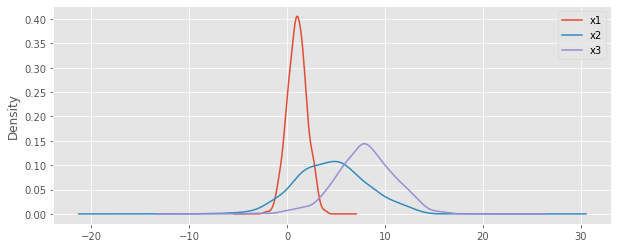

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 4))

df = pd.DataFrame(data, columns=['x1', 'x2', 'x3'])
df.plot.kde(ax=ax)

_ = ax.legend()

## Probability density functions

In order to estimate $I(X_1, X_2)$, $I(X_1, X_3)$ and $I(X_2, X_3)$, we need the following combinations of probability density functions `PDFs`.

* $I(X_1, X_2)$ : $p(x_1, x_2)$, $p(x_1)$ and $p(x_2)$
* $I(X_1, X_3)$ : $p(x_1, x_3)$, $p(x_1)$ and $p(x_3)$
* $I(X_2, X_3)$ : $p(x_2, x_3)$, $p(x_2)$ and $p(x_3)$

Note that we model each PDF with a multivariate gaussian distribution. We use `multivariate_normal` from `scipy.stats`, and evaluate each data point simply with the `pdf` function.

In [3]:
from scipy.stats import multivariate_normal

# marginal PDFs
d1 = multivariate_normal(means[0], cov[0, 0])
d2 = multivariate_normal(means[1], cov[1, 1])
d3 = multivariate_normal(means[2], cov[2, 2])

# joint PDFs
jd12 = multivariate_normal(means[[0, 1]], cov[[0, 1]][:, [0, 1]])
jd13 = multivariate_normal(means[[0, 2]], cov[[0, 2]][:, [0, 2]])
jd23 = multivariate_normal(means[[1, 2]], cov[[1, 2]][:, [1, 2]])

Since there are `infinitely finite` values of $X_1$, $X_2$ and $X_3$, we pick arbitrarily 100 equally spaced points from each of these variable's domains. Thus, when computing the mutual information, we will have $100 \times 100 = 1000$ pairs of values to evaluate. 

In [4]:
x1_vals = np.linspace(x1.min(), x1.max(), num=100, endpoint=True)
x2_vals = np.linspace(x2.min(), x2.max(), num=100, endpoint=True)
x3_vals = np.linspace(x3.min(), x3.max(), num=100, endpoint=True)

print(len(x1_vals), len(x2_vals), len(x3_vals))

100 100 100


## Estimate mutual information

Now that we have a range of values per variable and also the marginal and joint distributions to give us the probabilities, we can compute the mutual information.

Here's $I(X_1, X_2)$.

In [5]:
import itertools

triplets = ((jd12.pdf(tup), d1.pdf(tup[0]), d2.pdf(tup[1])) for tup in itertools.product(*[x1_vals, x2_vals]))
np.sum([p_xy * (np.log(p_xy) - np.log(p_x) - np.log(p_y)) for p_xy, p_x, p_y in triplets])

77.21136767734559

Here's $I(X_1, X_3)$.

In [6]:
triplets = ((jd13.pdf(tup), d1.pdf(tup[0]), d3.pdf(tup[1])) for tup in itertools.product(*[x1_vals, x3_vals]))
np.sum([p_xy * (np.log(p_xy) - np.log(p_x) - np.log(p_y)) for p_xy, p_x, p_y in triplets])

0.005160087840838103

Here's $I(X_2, X_3)$.

In [7]:
triplets = ((jd23.pdf(tup), d2.pdf(tup[0]), d3.pdf(tup[1])) for tup in itertools.product(*[x2_vals, x3_vals]))
np.sum([p_xy * (np.log(p_xy) - np.log(p_x) - np.log(p_y)) for p_xy, p_x, p_y in triplets])

0.006439296428914668

As expected, $I(X_1, X_2) > I(X_1, X_3)$ and $I(X_1, X_2) > I(X_2, X_3)$.